# ANALISIS Y PREDICCIÓN DE SERIES TEMPORALES 
## Dataset: "Precio del Oro en 2023 y 2024"
### Nombre: Sebastian Calderon

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn-v0_8-darkgrid')
# pmdarima
# !pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# skforecast
#!pip install skforecast
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax
from sklearn.metrics import mean_absolute_error,  mean_squared_error
import seaborn as sns
import warnings

### 1. Introdución:

Este trabajo tiene como objetivo desarrollar un modelo para predecir el precio del oro utilizando una serie temporal con datos de 2023 y 2024. El dataset contiene una columna con fechas y otra con el precio en dólares, con registros diarios, aunque no todos los días presentan un valor.

Para la modelización, se emplearán los métodos de Holt, Holt-Winters y ARIMA, que permiten capturar tendencias y patrones estacionales en los datos. Con estos modelos, se busca generar predicciones que faciliten el análisis y la toma de decisiones en el mercado del oro.

In [4]:
#Importación y Presentación del Dataset.

data_gold = pd.read_csv('C:/Users/Usuario/Documents/PPTs Master/Mineria de Datos 2/Tarea/Gold Price.csv')
data_gold = data_gold.drop(columns=['Open', 'High', 'Low', 'Volume', 'Chg%'])
data_gold.head()

,Date,Price
0,2024-11-06,77030
1,2024-11-05,78490
2,2024-11-04,78401
3,2024-11-01,78829
4,2024-10-31,78326


In [5]:
# Modicación del dataframe para que la fecha sea el indice.

data_gold.columns=['Date','Price']
data_gold['Date']=pd.to_datetime(data_gold['Date'])
data_gold.index=data_gold['Date']
del data_gold['Date']
print(data_gold.head())

            Price
Date             
2024-11-06  77030
2024-11-05  78490
2024-11-04  78401
2024-11-01  78829
2024-10-31  78326


### 2. Representación Grafica y Descomposición

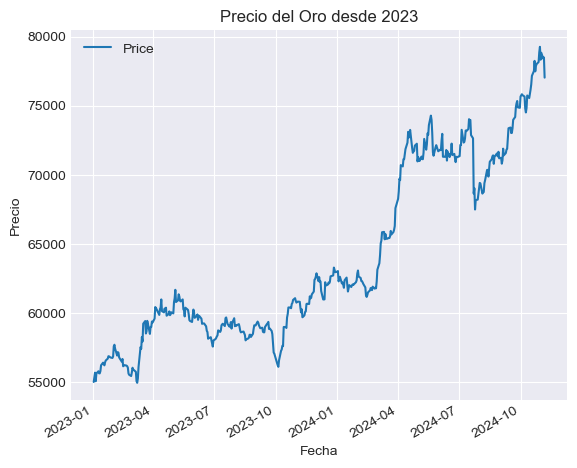

In [6]:
#Representación Grafica del dataset

sns.lineplot(data_gold)
plt.xticks(rotation=30, ha='right')
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
plt.title('Precio del Oro desde 2023')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

La serie no es estacionaria, ya que presenta una tendencia y un posible comportamiento estacional, aproximadamente cada seis meses. Sin embargo, esto deberá analizarse con mayor detalle más adelante.

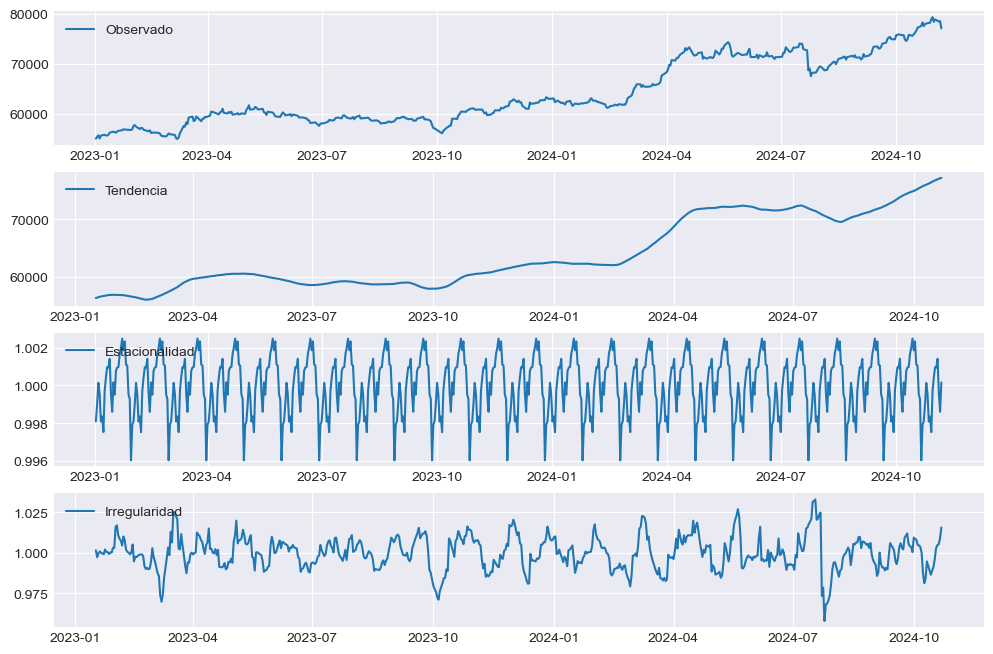

In [7]:
#Descomposición 

price = data_gold['Price'].resample('D').mean().interpolate()
result = seasonal_decompose(price, model='multiplicative', period=30)
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Irregularidad')
plt.legend(loc='upper left')
plt.show()

La tendencia de la serie es consistentemente creciente. En cuanto a la estacionalidad, se observa que el mismo patrón tiende a repetirse aproximadamente cada 30 días (cada mes).

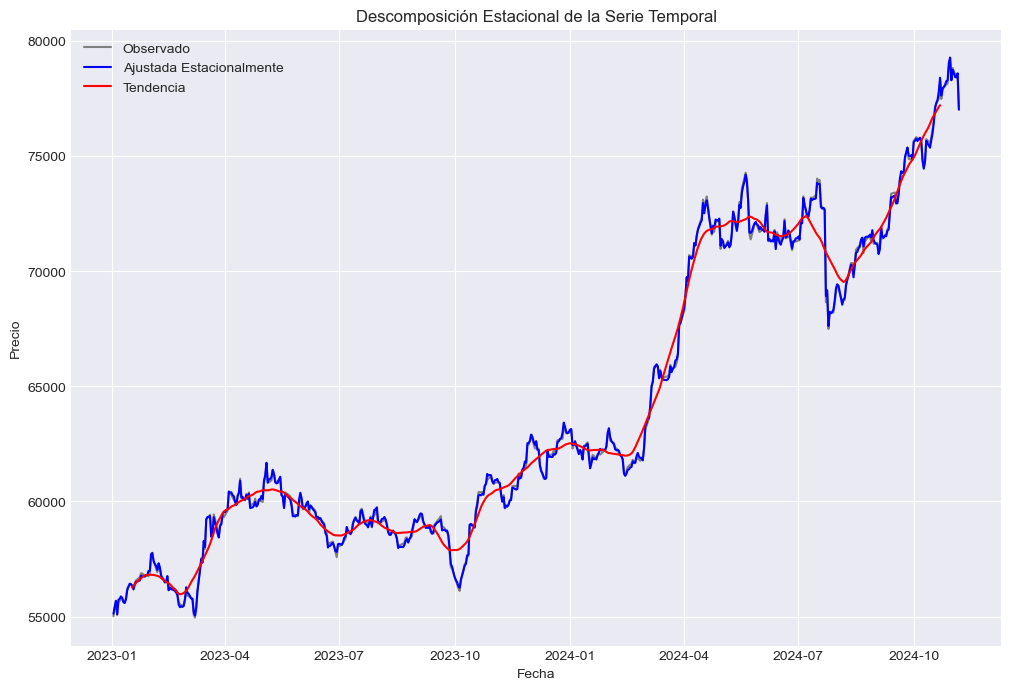

In [8]:
#Grafica conjunta de la Tendencia, el Ajuste Estacional y la Serie Observada.

plt.figure(figsize=(12, 8))
plt.plot(result.observed, label='Observado', color='grey')
plt.plot(result.observed/result.seasonal, label='Ajustada Estacionalmente', color='blue')
plt.plot(result.trend, label='Tendencia', color='red')
plt.legend()
plt.title('Descomposición Estacional de la Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

### 3. Modificación del Dataset
Dado que el período de estacionalidad en la serie parece ser de un mes, removeré los datos del último mes para evaluar la eficiencia de los métodos de predicción.

In [9]:
# Importando la serie modificada.

serie_nueva = pd.read_csv('C:/Users/Usuario/Documents/PPTs Master/Mineria de Datos 2/Tarea/Gold Price_TR.csv')
serie_nueva = serie_nueva.drop(columns=['Open', 'High', 'Low', 'Volume', 'Chg%'])
serie_nueva.columns=['Date','Price']
serie_nueva['Date']=pd.to_datetime(serie_nueva['Date'])
serie_nueva.index=serie_nueva['Date']
del serie_nueva['Date']
serie_nueva.head()
serie_nueva = serie_nueva.sort_index()
#Reindexando mi serie debido a que a pesar de ser diaria, no tiene registro de todos los dias.
full_index = pd.date_range(start=serie_nueva.index.min(), end=serie_nueva.index.max(), freq='D')
serie_nueva = serie_nueva.reindex(full_index)
serie_nueva = serie_nueva.ffill()  


### 4. Modelos de Predicción.

A continuación, se realizarán predicciones utilizando tres modelos: Simple, Holt y Holt-Winters.

In [10]:
# 1. Modelo Simple

gold_R = serie_nueva.Price.loc['2023-01-02':]
full_index = pd.date_range(start=gold_R.index.min(), end=gold_R.index.max(), freq='D')
gold_R = gold_R.reindex(full_index)
gold_R = gold_R.interpolate(method='linear') 
modelo_ses = sm.tsa.SimpleExpSmoothing(gold_R, initialization_method="estimated").fit()
gold_s1 = modelo_ses.forecast(steps=30)
print(modelo_ses.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  Price   No. Observations:                  638
Model:             SimpleExpSmoothing   SSE                       96605179.137
Optimized:                       True   AIC                           7613.939
Trend:                           None   BIC                           7622.856
Seasonal:                        None   AICC                          7614.003
Seasonal Periods:                None   Date:                 Mon, 10 Feb 2025
Box-Cox:                        False   Time:                         23:55:18
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9973763                alpha                 True
initial_level              55026.721                

In [11]:
# 2. Modelo Holt

modelo_holt = sm.tsa.ExponentialSmoothing(gold_R, trend='add', damped=False).fit()
predicciones = modelo_holt.forecast(steps=30)
modelo_holt.summary()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17520\2585772484.py:3: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  modelo_holt = sm.tsa.ExponentialSmoothing(gold_R, trend='add', damped=False).fit()
C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Price,No. Observations:,638
Model:,ExponentialSmoothing,SSE,96493669.624
Optimized:,True,AIC,7617.202
Trend:,Additive,BIC,7635.036
Seasonal:,None,AICC,7617.336
Seasonal Periods:,None,Date:,"Mon, 10 Feb 2025"
Box-Cox:,False,Time:,23:55:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0001,beta,True


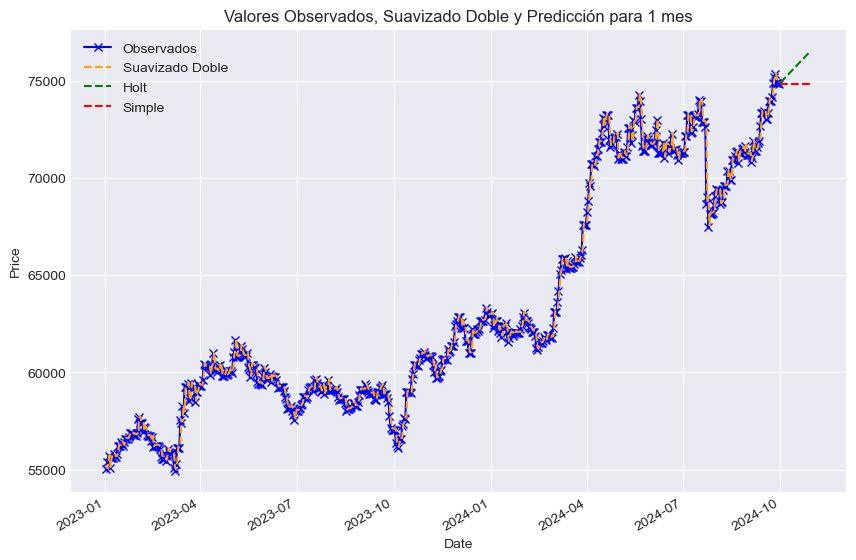

In [12]:
# Grafica de predicción conjunta del modelo Simple y el modelo Holt.

plt.figure(figsize=(10, 6))
plt.plot(gold_R.index, gold_R, label='Observados', marker='x', linestyle='-', color='blue')
plt.plot(gold_R.index, modelo_holt.fittedvalues, label='Suavizado Doble', linestyle='--', color='orange')
plt.plot(predicciones.index, predicciones, label='Holt', linestyle='--',color='green')
plt.plot(gold_s1.index, gold_s1, label='Simple', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Valores Observados, Suavizado Doble y Predicción para 1 mes')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

Aparentemente, ni el modelo simple ni el modelo de Holt ofrecen un buen desempeño en la predicción de esta serie de datos.

In [13]:
# 3. Modelo Holt-Winters

ultima_fecha = gold_R.index.max()
nuevo_indice = pd.date_range(start=ultima_fecha + pd.Timedelta(days=1), periods=30, freq='D')
modelo_holt_winters = sm.tsa.ExponentialSmoothing(gold_R, trend='add', seasonal='additive', seasonal_periods=30).fit()
predicciones_hw = pd.Series(modelo_holt_winters.forecast(steps=30).values, index=nuevo_indice)
modelo_holt_winters.summary()

C:\Users\Usuario\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,Price,No. Observations:,638
Model:,ExponentialSmoothing,SSE,105935352.368
Optimized:,True,AIC,7736.761
Trend:,Additive,BIC,7888.344
Seasonal:,Additive,AICC,7741.193
Seasonal Periods:,30,Date:,"Mon, 10 Feb 2025"
Box-Cox:,False,Time:,23:55:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9596429,alpha,True
smoothing_trend,0.0001,beta,True


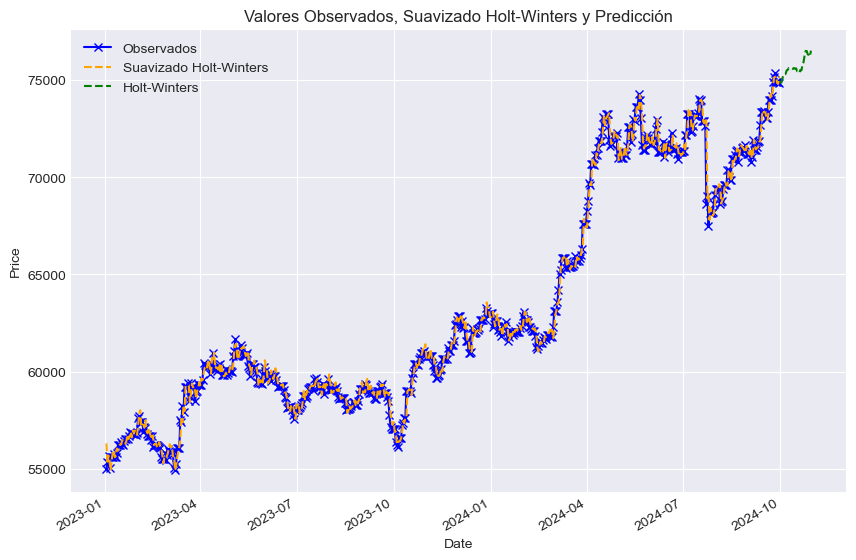

In [14]:
# Grafica de Predicción del Modelo Holt-Winters

plt.figure(figsize=(10, 6))
plt.plot(gold_R.index, gold_R, label='Observados', marker='x', linestyle='-', color='blue')
plt.plot(gold_R.index, modelo_holt_winters.fittedvalues, label='Suavizado Holt-Winters', linestyle='--', color='orange')
plt.plot(predicciones_hw.index, predicciones_hw, label='Holt-Winters', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Valores Observados, Suavizado Holt-Winters y Predicción')
plt.legend()
plt.xticks(rotation=30, ha='right')
plt.show()

En este caso, el modelo de Holt-Winters parece ser el más indicado para predecir el precio del oro. Aunque el modelo de Holt por sí solo no ofrece una mala predicción, Holt-Winters demuestra un mejor desempeño. A continuación, presentamos la expresión matemática del modelo.

In [15]:
#Expresión Matematica del Modelo Holt- Winters

nivel = modelo_holt_winters.level
tendencia = modelo_holt_winters.trend
estacionalidad = modelo_holt_winters.season

print(f"Expresión del Modelo Holt-Winters: Y(t) = ({nivel.iloc[-1]:.2f} + {tendencia.iloc[-1]:.2f} * t) * {estacionalidad.iloc[-1]:.2f}")



Expresión del Modelo Holt-Winters: Y(t) = (74835.44 + 54.96 * t) * 8.56


### 5. Modelo ARIMA

A continuación, se construirá el modelo ARIMA, aplicando diferenciación a la serie para hacerla estacionaria. Se analizarán las funciones de autocorrelación y autocorrelación parcial para determinar los parámetros del modelo.

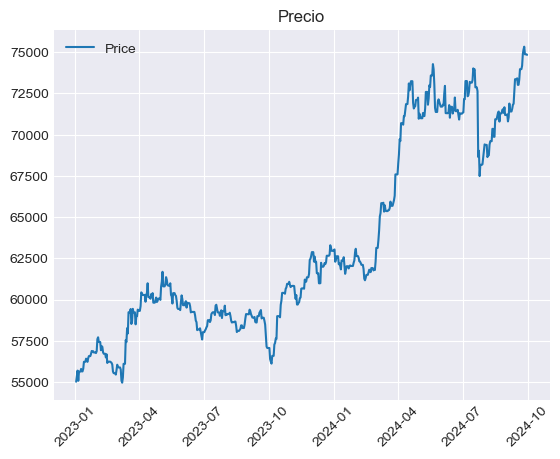

In [16]:
# Grafica de nuestra serie de datos nueva (con el ultimo mes de datos eliminado)

sns.lineplot(data=serie_nueva)
plt.title('Precio')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()

In [17]:
#Test de Dickey-Fuller para verificar la estacionariedad

resultado_adf = adfuller(serie_nueva['Price'])
print(f"Estadístico ADF: {resultado_adf[0]}")
print(f"Valor p: {resultado_adf[1]}")
if resultado_adf[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie NO es estacionaria")

Estadístico ADF: -0.46354035351342726
Valor p: 0.898937134990542
La serie NO es estacionaria


In [18]:
# Diferenciación de Primer Nivel para que sea estacionaria

serie_diff = serie_nueva['Price'].diff().dropna()
resultado_adf = adfuller(serie_diff)
print(f"Estadístico ADF: {resultado_adf[0]}")
print(f"Valor p: {resultado_adf[1]}")
if resultado_adf[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie NO es estacionaria")

Estadístico ADF: -6.506421125023587
Valor p: 1.1282246353713261e-08
La serie es estacionaria


Solo tuve que aplicar diferenciación de primer nivel para volver mi serie estacionaria.

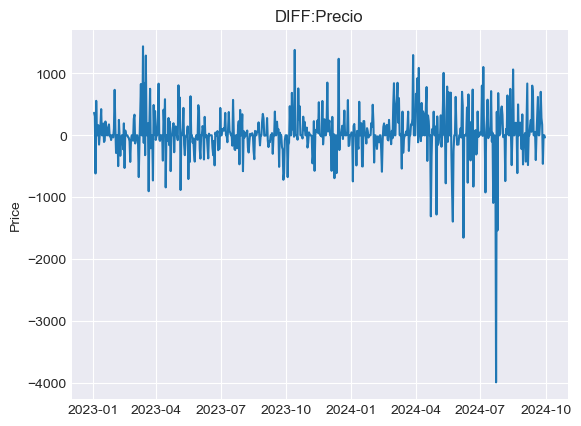

In [19]:
#Grafica de mi serie diferenciada

sns.lineplot(serie_diff)
plt.title('DIFF:Precio')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

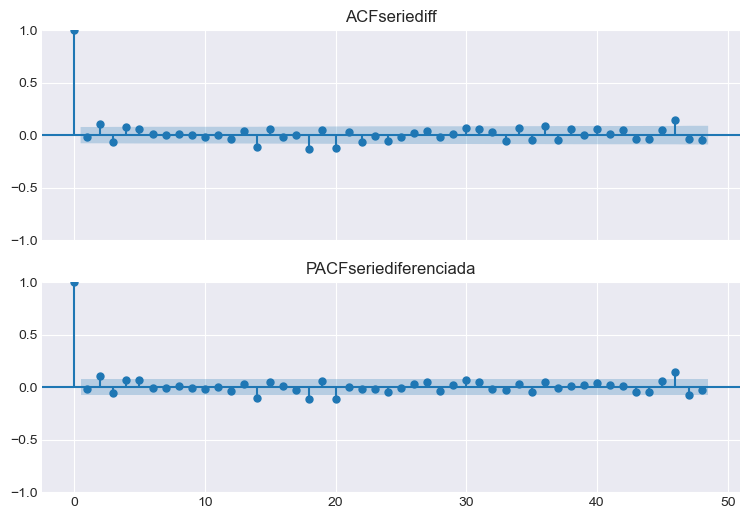

In [20]:
# Grafica de mi función de autocorrelación y autocorrelación parcial.

fig,axs=plt.subplots(nrows=2,ncols=1,
figsize=(9,6),sharex=True)
plot_acf(serie_diff,ax=axs[0],
lags=48,alpha=0.05)
axs[0].set_title('ACFseriediff')
plot_pacf(serie_diff,ax=axs[1],
lags=48,alpha=0.05)
axs[1].set_title('PACFseriediferenciada');

### 6. Construcción del Modelo Inicial

Ahora puedo determinar los parámetros para mi ARIMA no estacional, que en este caso son:

p = 1, d = 1, q = 1, y P = 1, D = 1, Q = 1.

Esto corresponde a un modelo ARIMA(1,1,1)(1,1,1)30

La ecuación que representa el ARIMA es:

$$
(1 - \phi_1 B)(1 - \Phi_1 B^{30})(1 - B)(1 - B^{30}) y_t = (1 + \theta_1 B)(1 + \Theta_1 B^{30}) \epsilon_t
$$



In [21]:
# Creación y ajuste del modelo ARIMA con los parametros iniciales.

modelo = SARIMAX(endog=serie_nueva, order=(1, 1, 1),seasonal_order=(1, 1, 1, 30))
modelo_res = modelo.fit(disp=0)
warnings.filterwarnings("default")
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  638
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -4607.058
Date:                            Mon, 10 Feb 2025   AIC                           9224.115
Time:                                    23:55:39   BIC                           9246.158
Sample:                                01-02-2023   HQIC                          9232.692
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9683      0.120     -8.088      0.000      -1.203      -0.734
ma.L1          0.9729      0.115      8.433      0.000       0.747       1.199
ar.S.L30       0.2850      0.015     18.442      0.000       0.255       0.315
ma.S.L30      -0.8068      0.023    -34.908      0.000      -0.852      -0.761
sigma2      1.766e+05   3861.679     45.731      0.000    1.69e+05    1.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):              4733.55
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                            -1.76
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 7. Predicciones Modelo Inicial

In [22]:
# Calculo de las Predicciones

predicciones_statsmodels=modelo_res.get_forecast(steps=27).predicted_mean
predicciones_statsmodels.name='predicciones_statsmodels'
fecha_inicio_pred = serie_nueva.index[-1] 
predicciones_statsmodels.index = pd.date_range(start=fecha_inicio_pred, periods=27, freq='D')

# Comparación de Valores Reales con Valores Predichos

data_gold = data_gold.sort_index()
datos_futuro = data_gold.loc['2024-09-30':'2024-11-06']
datos_futuro = datos_futuro['Price']

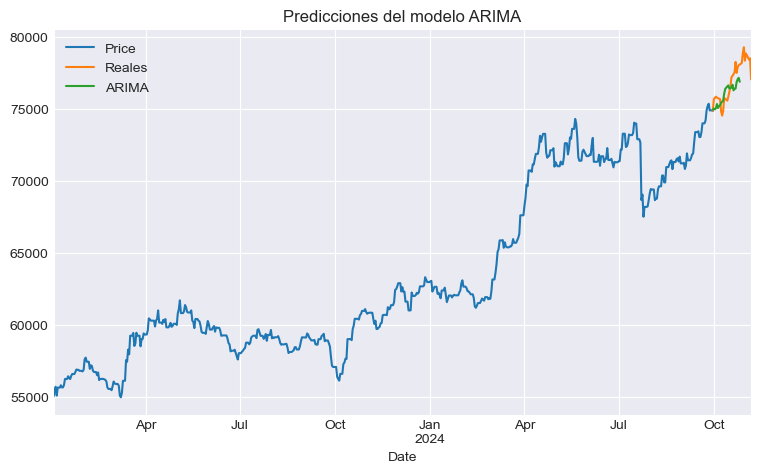

In [23]:
# Grafico de las Predicciones

fig, ax = plt.subplots(figsize=(9,5))
serie_nueva.plot(ax=ax, label='Serie')
datos_futuro.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='ARIMA')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend()
plt.show()

In [24]:
# Calculo de las Medidas de Bondad de Ajuste

mse = mean_squared_error(datos_futuro, predicciones_statsmodels)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mae = mean_absolute_error(datos_futuro, predicciones_statsmodels)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 1530089.7933498006
Root Mean Squared Error (RMSE): 1236.967983963126
Mean Absolute Error (MAE): 969.1964883144246


### Contrucción del Nuevo Modelo 
Obtendre los mejores parametros mediante AUTOARIMA.

In [25]:
# Uso de AutoArima para calcular los parametros del modelo automaticamente.

modelo_auto = auto_arima(y=serie_nueva,start_p=0,start_q=0,max_p=3,max_q=3,seasonal=True,test='adf',m=30,d=None,D=None,trace=True,
error_action='ignore', suppress_warnings=True,stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[30] intercept   : AIC=9405.093, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9406.684, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=9405.093, Time=0.51 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=9405.132, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9408.767, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[30] intercept   : AIC=9403.145, Time=0.49 sec
 ARIMA(0,1,0)(0,0,2)[30] intercept   : AIC=9405.022, Time=2.35 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : AIC=9403.095, Time=0.94 sec
 ARIMA(0,1,0)(2,0,0)[30] intercept   : AIC=9405.086, Time=3.50 sec
 ARIMA(0,1,0)(2,0,1)[30] intercept   : AIC=9406.898, Time=9.85 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=9405.087, Time=0.49 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=9402.808, Time=1.16 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=9406.828, Time=0.17 sec
 ARIMA(1,1,1)(2,0,0)[30] intercept   : AIC=9404.790, Time=4.99 sec
 ARIMA(1,1,1)(1,0,1

In [26]:
# Creación y ajuste del nuevo modelo ARIMA con los parametros obtenidos.

warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
modelo2 = SARIMAX(endog=serie_nueva, order=(2, 1, 2),seasonal_order=(0, 1, 0, 30))
#A pesar de que SARIMAX me dice que P, D, Q son (0,0,1), se ajusta mejor con (0,1,0)
modelo_res2 = modelo2.fit(disp=0)
warnings.filterwarnings("default")
modelo_res2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Price   No. Observations:                  638
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 30)   Log Likelihood               -4664.395
Date:                             Mon, 10 Feb 2025   AIC                           9338.791
Time:                                     23:58:33   BIC                           9360.833
Sample:                                 01-02-2023   HQIC                          9347.367
                                      - 09-30-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0417      0.041    -25.312      0.000      -1.122      -0.961
ar.L2         -0.8747      0.038    -22.912      0.000      -0.949      -0.800
ma.L1          1.0522      0.028     37.874      0.000       0.998       1.107
ma.L2          0.9482      0.025     38.008      0.000       0.899       0.997
sigma2      2.825e+05   9482.936     29.795      0.000    2.64e+05    3.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):              1901.57
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

La expresión algebraica del nuevo modelo es: 

$$
(1 - \phi_1 B - \phi_2 B^2)(1 - B)(1 - B^{30}) y_t = (1 + \theta_1 B + \theta_2 B^2) \epsilon_t
$$

### Predicción Nuevo Modelo

In [27]:
# Calculo de las Predicciones

predicciones_statsmodels2=modelo_res2.get_forecast(steps=27).predicted_mean
predicciones_statsmodels2.name='predicciones_statsmodels'
fecha_inicio_pred = serie_nueva.index[-1]  
predicciones_statsmodels2.index = pd.date_range(start=fecha_inicio_pred, periods=27, freq='D')

# Comparación de Valores Reales con Valores Predichos

data_gold = data_gold.sort_index()
datos_futuro = data_gold.loc['2024-09-30':'2024-11-06']
datos_futuro = datos_futuro['Price']

### Comparación de los dos Modelos

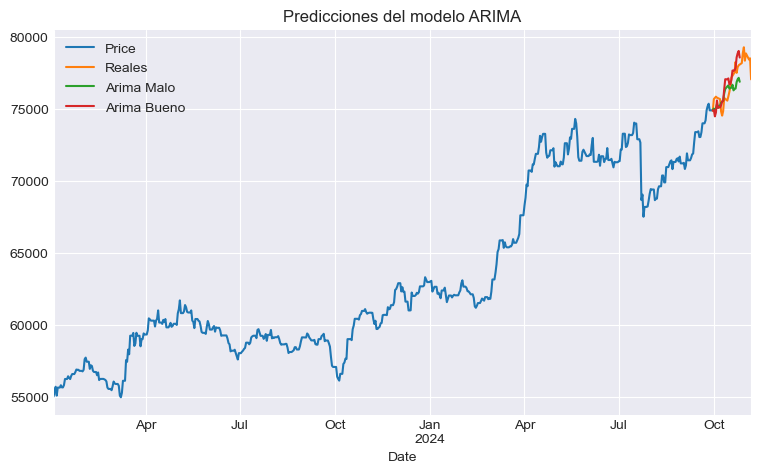

In [28]:
#Grafica de la predicción de los dos modelos.

fig, ax = plt.subplots(figsize=(9,5))
serie_nueva.plot(ax=ax, label='Serie')
datos_futuro.plot(ax=ax, label='Reales')
predicciones_statsmodels.plot(ax=ax, label='Arima Malo')
predicciones_statsmodels2.plot(ax=ax, label='Arima Bueno')
ax.set_title('Predicciones del modelo ARIMA')
ax.legend()
plt.show()

In [29]:
# Calculo de las medidas de bondad de ajuste de los dos modelos.

print(f'Modelo 1:')
mse = mean_squared_error(datos_futuro, predicciones_statsmodels)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mae = mean_absolute_error(datos_futuro, predicciones_statsmodels)
print(f'Mean Absolute Error (MAE): {mae}')

print(f'Modelo 2:')
mse = mean_squared_error(datos_futuro, predicciones_statsmodels2)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
mae = mean_absolute_error(datos_futuro, predicciones_statsmodels2)
print(f'Mean Absolute Error (MAE): {mae}')

Modelo 1:
Mean Squared Error (MSE): 1530089.7933498006
Root Mean Squared Error (RMSE): 1236.967983963126
Mean Absolute Error (MAE): 969.1964883144246
Modelo 2:
Mean Squared Error (MSE): 612442.9815268645
Root Mean Squared Error (RMSE): 782.5873635108508
Mean Absolute Error (MAE): 635.6119393644055


### Conclusión

La mejor opción es el Modelo 2: ARIMA(2,1,2)(0,1,0)30, ya que presenta un mejor desempeño en comparación con el Modelo 1: ARIMA(1,1,1)(1,1,1)30, según las medidas de bondad de ajuste.

En primer lugar, el Modelo 2 tiene un Mean Squared Error (MSE) significativamente más bajo (612,443) en comparación con el Modelo 1 (1,530,090), lo que indica que los errores cuadráticos entre las predicciones y los valores reales son menores en el Modelo 2, sugiriendo un mejor ajuste general.

El Root Mean Squared Error (RMSE) también es menor en el Modelo 2 (782.59) frente al Modelo 1 (1,236.97), lo que refuerza la idea de que el Modelo 2 tiene una mayor precisión en la predicción, ya que este valor está en las mismas unidades que los datos originales y muestra menores desviaciones.

Finalmente, el Mean Absolute Error (MAE) del Modelo 2 (635.61) también es inferior al del Modelo 1 (969.20), lo que significa que, en promedio, el error absoluto de las predicciones en el Modelo 2 es más pequeño.

En resumen, el Modelo 2 tiene menores errores en todas las métricas de bondad de ajuste, lo que sugiere que ofrece un ajuste superior en comparación con el Modelo 1.